The notebook shows an example how text files, labelled for sentiment (positive or negative), can be converted to numerical representations using a large language model (DistillBERT ([Sanh et al 2019](https://arxiv.org/abs/1910.01108)), in this example) and then used to train a machine learning model capable of classifying new texts by sentiment.

As an example, we will use a corpus of movie reviews first used in Pang and Lee (2004), for details see [here](http://www.cs.cornell.edu/people/pabo/movie-review-data/).

Ensure that PyTorch and transformers are installed:

In [1]:
!pip install torch
!pip install transformers

'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# setting logging to print only error messages of sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import GridSearchCV

# execution time
from timeit import default_timer as timer
from datetime import timedelta

# Load the data

If the data has not been downloaded before, download it, and save to a folder called "datasets", alongside this notebook.

In [3]:
import os
import urllib
import tarfile

url = "https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz"
    
def download_data(url):
    """Download the data and extract the mo
    """
    
    # if the "datasets" folder does not exist, create it
    if not os.path.exists("datasets"):
        os.makedirs("datasets")
    
    # if the archived file does not exist, download it
    if not os.path.exists("datasets/review_polarity.tar.gz"):
        urllib.request.urlretrieve(url, "datasets/review_polarity.tar.gz")
    
    # if the unpacked file does not exist, unpack it
    if not os.path.exists("datasets/txt_sentoken"):
        infile = tarfile.open("datasets/review_polarity.tar.gz")
        infile.extractall(path="datasets")
        infile.close()

download_data(url)

The code above will produce a folder inside "datasets", called "txt_sentoken". That folder will contain two subfolders - "pos" (containing 1000 files manually labelled as positive) and "neg" (containing 1000 files manually labelled as "negative"). Each file is a separate movie review, after minimal normalization (inserting spaces around punctuation symbols, lower-casing all words, etc).

We will use Scikit-learn's `load_files` function to load the data and then store it in a Pandas dataframe:

In [4]:
from sklearn.datasets import load_files

# loading all files. 
movie = load_files("./datasets/txt_sentoken/", shuffle=True)

In [5]:
len(movie.data)

2000

In [6]:
# target names ("classes") are automatically generated from subfolder names
movie.target_names

['neg', 'pos']

In [7]:
# First file seems to be about a Schwarzenegger movie. 
print(movie.data[0])

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is 

In [8]:
movie.target[0]

0

In [9]:
df = pd.DataFrame({"text": movie.data, "label": movie.target})
df["text"] = df["text"].astype("str")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 23.6+ KB


# Train-test split

In [10]:
from sklearn.model_selection import train_test_split

docs_train, docs_test, ytrain, ytest = train_test_split(df["text"], df["label"], 
                                                          test_size=0.2, random_state=7)

In [11]:
print(f"{len(docs_train)} train and {len(docs_test)} test instances")

1600 train and 400 test instances


# Document embeddings

Note DistillBERT will consume maximum 512 tokens of the document and truncate anything beyond this length.

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# other options:
#prajjwal1/bert-tiny (L=2, H=128)
#prajjwal1/bert-mini (L=4, H=256)
#prajjwal1/bert-small (L=4, H=512)
#prajjwal1/bert-medium (L=8, H=512)
# search for other models: https://huggingface.co/models?sort=trending&search=distilbert

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
def get_embeddings(text):
    """Given a document as a string, returns a numpy ndarray
    """
    global tokenizer, model, device

    tokenized_texts = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    
    tokenized_texts = {k: v.clone().detach().to(device) for k,v in tokenized_texts.items()}

    with torch.no_grad():
      hidden = model(**tokenized_texts)
    
    return hidden.last_hidden_state[:, 0, :].to("cpu").numpy()[0]

In [14]:
output = get_embeddings("This is an example.")
output.shape

(768,)

In [15]:
output = get_embeddings("This is a longer example.")
output.shape

(768,)

In [16]:
output

array([-1.93969756e-01, -1.48303643e-01, -5.09748012e-02, -2.91312665e-01,
       -2.30745047e-01, -2.28560850e-01,  7.34069422e-02,  2.70712882e-01,
       -3.03023607e-01, -2.79529035e-01, -2.09429100e-01, -1.01992764e-01,
       -2.22981960e-01,  9.54697654e-02,  1.54272377e-01,  2.58993715e-01,
       -1.16709098e-01,  7.34619275e-02,  1.63612321e-01, -1.62993044e-01,
        1.82859600e-02, -1.41642252e-02, -3.76870185e-02, -1.16056919e-01,
        9.08977538e-02, -6.57474250e-02,  1.01757191e-01, -1.77987069e-01,
        3.98330912e-02,  9.34918746e-02,  5.78726176e-03,  1.45592138e-01,
       -1.44652026e-02, -2.54461206e-02,  1.86843812e-01, -7.73996264e-02,
        1.36657476e-01, -7.02458099e-02,  1.15305275e-01,  4.84217107e-02,
       -8.14796984e-03, -6.96763918e-02,  1.89358130e-01,  1.13946274e-01,
       -1.04039691e-01,  1.75677687e-02, -2.07787609e+00, -8.98039192e-02,
       -2.23061740e-01, -3.48453611e-01, -2.12638259e-01,  4.84841838e-02,
        2.07891375e-01,  

In [17]:
Xtrain = docs_train.apply(get_embeddings)
Xtrain = np.stack(Xtrain)
Xtrain.shape

(1600, 768)

In [18]:
Xtest = docs_test.apply(get_embeddings)
Xtest = np.stack(Xtest)
Xtest.shape

(400, 768)

# Train models

## Baseline

Classifying everything as "pos"

In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_fscore_support

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(Xtrain, ytrain)
yhat = dummy_clf.predict(Xtrain)

p, r, f, s = precision_recall_fscore_support(ytrain, yhat, average="macro", zero_division=0.0)
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")

Precision: 0.254
Recall: 0.500
F score: 0.337


## Decision Trees

In [20]:
start = timer()

from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(random_state=7)

# specify the hyperparameters and their values
# 3 x 3 = 9 combinations in the grid
param_grid = {
    'max_depth': [15, 30, 50],
    'min_samples_split': [10, 20, 50],
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(dtree, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True)
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:00:54.191419


In [21]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
1,"{'max_depth': 15, 'min_samples_split': 20}",0.933851,0.618080,33.813911
5,"{'max_depth': 30, 'min_samples_split': 50}",0.859126,0.614071,28.523828
8,"{'max_depth': 50, 'min_samples_split': 50}",0.859126,0.614071,28.523828
2,"{'max_depth': 15, 'min_samples_split': 50}",0.854734,0.613490,28.224470
0,"{'max_depth': 15, 'min_samples_split': 10}",0.970122,0.605346,37.601051
4,"{'max_depth': 30, 'min_samples_split': 20}",0.938568,0.601217,35.943155
7,"{'max_depth': 50, 'min_samples_split': 20}",0.938568,0.601217,35.943155
3,"{'max_depth': 30, 'min_samples_split': 10}",0.976862,0.600481,38.529564
6,"{'max_depth': 50, 'min_samples_split': 10}",0.976862,0.600481,38.529564


## Random Forest

In [22]:
start = timer()

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=7)

# specify the hyperparameters and their values
# 4 x 3 x 3 = 36 combinations in the grid
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [5, 15, 30],
    'min_samples_split': [5, 10, 20]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True)
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:30:10.456463


In [23]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
31,"{'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 1000}",1.000000,0.751836,24.816435
14,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 500}",1.000000,0.751666,24.833363
15,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 1000}",1.000000,0.750974,24.902628
18,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 500}",1.000000,0.748567,25.143267
27,"{'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 1000}",1.000000,0.747945,25.205525
34,"{'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 500}",1.000000,0.745525,25.447529
26,"{'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 500}",1.000000,0.745465,25.453479
30,"{'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 500}",1.000000,0.745450,25.455024
22,"{'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 500}",0.999844,0.744919,25.496462
23,"{'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 1000}",0.999844,0.744265,25.561831


## Linear SVM

In [24]:
start = timer()

from sklearn.svm import LinearSVC

lsvm = LinearSVC(random_state=7, max_iter=10000)

# specify the hyperparameters and their values
# 7 combinations in the grid
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(lsvm, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:00:08.160295


In [25]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
3,{'C': 0.1},0.884903,0.787339,11.025431
2,{'C': 0.01},0.814711,0.771899,5.254880
4,{'C': 1},0.949670,0.769154,19.008285
5,{'C': 5},0.992654,0.742930,25.157198
6,{'C': 10},0.999219,0.732253,26.717460
1,{'C': 0.001},0.746130,0.723737,3.001248
0,{'C': 0.0001},0.669271,0.651208,2.698938


# Evaluate on test

In [26]:
from sklearn.metrics import precision_recall_fscore_support

yhat = grid_search.best_estimator_.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Precision: 0.8326833170829271
Recall: 0.834313134358356
F score: 0.8323228910536754


The accuracy scores on the test set turn out to be very similar to the one achieved during cross-validation.

Plot a confusion matrix:

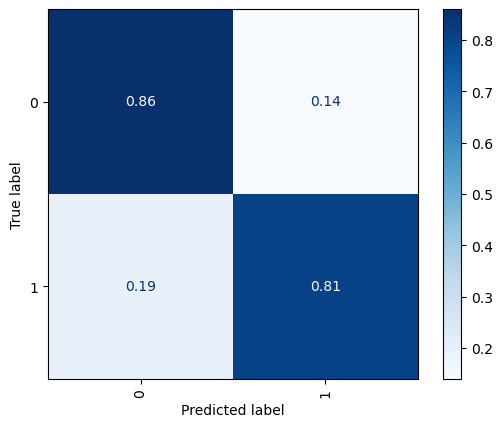

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(ytest, yhat, labels=grid_search.best_estimator_.classes_,
                                        xticks_rotation="vertical", normalize="true",
                                        cmap=plt.cm.Blues)

# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2024). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm